<a href="https://colab.research.google.com/github/shivangini831-sys/FitPulse-Health-Anomaly-Detection-From-Fitness-Devices/blob/main/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import plotly.express as px
from sklearn.cluster import KMeans
!pip install prophet scikit-learn

In [ ]:
heart_df = pd.read_csv('/content/drive/MyDrive/heart_rate.csv')
sleep_df = pd.read_csv('/content/drive/MyDrive/sleep.csv')


In [ ]:
heart_df.head(), sleep_df.head()


(             timestamp  heart_rate
 0  2024-01-01 00:00:00        72.5
 1  2024-01-01 00:15:00        69.7
 2  2024-01-01 00:30:00        74.0
 3  2024-01-01 00:45:00        78.8
 4  2024-01-01 01:00:00        70.4,
          date  sleep_hours
 0  2024-01-01         6.83
 1  2024-01-02         6.55
 2  2024-01-03         7.70
 3  2024-01-04         7.96
 4  2024-01-05         7.09)

In [ ]:
heart_df.rename(columns={'timestamp': 'ds', 'heart_rate': 'y'}, inplace=True)
heart_df['ds'] = pd.to_datetime(heart_df['ds'])


In [ ]:
model = Prophet()
model.fit(heart_df)

future = model.make_future_dataframe(periods=0)
forecast = model.predict(future)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [ ]:
heart_df['yhat'] = forecast['yhat']
heart_df['residual'] = heart_df['y'] - heart_df['yhat']

threshold = 2 * heart_df['residual'].std()
heart_df['anomaly'] = abs(heart_df['residual']) > threshold


In [ ]:
output_table = heart_df[['ds', 'y', 'yhat', 'residual', 'anomaly']]
output_table.head()


,ds,y,yhat,residual,anomaly
0,2024-01-01 00:00:00,72.5,75.355340,-2.855340,False
1,2024-01-01 00:15:00,69.7,75.215194,-5.515194,False
2,2024-01-01 00:30:00,74.0,75.128530,-1.128530,False
3,2024-01-01 00:45:00,78.8,75.096148,3.703852,False
4,2024-01-01 01:00:00,70.4,75.115409,-4.715409,False


In [ ]:
anomalies_only = output_table[output_table['anomaly'] == True]
anomalies_only.head()


,ds,y,yhat,residual,anomaly
110,2024-01-02 03:30:00,50.9,70.629590,-19.729590,True
179,2024-01-02 20:45:00,91.4,71.263220,20.136780,True
209,2024-01-03 04:15:00,97.9,70.949936,26.950064,True
220,2024-01-03 07:00:00,87.3,69.189461,18.110539,True
262,2024-01-03 17:30:00,45.0,70.003355,-25.003355,True


In [ ]:
from IPython.display import display
display(output_table)


,ds,y,yhat,residual,anomaly
0,2024-01-01 00:00:00,72.5,75.355340,-2.855340,False
1,2024-01-01 00:15:00,69.7,75.215194,-5.515194,False
2,2024-01-01 00:30:00,74.0,75.128530,-1.128530,False
3,2024-01-01 00:45:00,78.8,75.096148,3.703852,False
4,2024-01-01 01:00:00,70.4,75.115409,-4.715409,False
...,...,...,...,...,...
495,2024-01-06 03:45:00,81.1,69.369845,11.730155,False
496,2024-01-06 04:00:00,73.4,69.274014,4.125986,False
497,2024-01-06 04:15:00,77.8,69.129840,8.670160,False
498,2024-01-06 04:30:00,74.6,68.944492,5.655508,False


In [ ]:
X = heart_df[['y', 'residual']]
kmeans = KMeans(n_clusters=2, random_state=42)
heart_df['cluster'] = kmeans.fit_predict(X)

anomaly_cluster = heart_df.groupby('cluster')['residual'].mean().idxmax()
heart_df['cluster_anomaly'] = heart_df['cluster'] == anomaly_cluster


In [ ]:
from sklearn.cluster import KMeans
cluster_output_table = heart_df[
    ['ds', 'y', 'residual', 'cluster', 'cluster_anomaly']
]

cluster_output_table.head()


,ds,y,residual,cluster,cluster_anomaly
0,2024-01-01 00:00:00,72.5,-2.855340,1,False
1,2024-01-01 00:15:00,69.7,-5.515194,1,False
2,2024-01-01 00:30:00,74.0,-1.128530,0,True
3,2024-01-01 00:45:00,78.8,3.703852,0,True
4,2024-01-01 01:00:00,70.4,-4.715409,1,False


In [ ]:
cluster_anomalies_only = cluster_output_table[
    cluster_output_table['cluster_anomaly'] == True
]

cluster_anomalies_only.head()


,ds,y,residual,cluster,cluster_anomaly
2,2024-01-01 00:30:00,74.0,-1.128530,0,True
3,2024-01-01 00:45:00,78.8,3.703852,0,True
6,2024-01-01 01:30:00,80.3,5.017664,0,True
7,2024-01-01 01:45:00,76.6,1.189920,0,True
9,2024-01-01 02:15:00,76.2,0.508736,0,True


In [ ]:
cluster_output_table.to_csv(
    "heart_rate_cluster_anomaly_table.csv",
    index=False
)


In [ ]:
heart_df['final_anomaly'] = (
    heart_df['anomaly'] | heart_df['cluster_anomaly']
)

final_output_table = heart_df[
    ['ds', 'y', 'yhat', 'residual', 'anomaly', 'cluster_anomaly', 'final_anomaly']
]

final_output_table.head()


,ds,y,yhat,residual,anomaly,cluster_anomaly,final_anomaly
0,2024-01-01 00:00:00,72.5,75.355340,-2.855340,False,False,False
1,2024-01-01 00:15:00,69.7,75.215194,-5.515194,False,False,False
2,2024-01-01 00:30:00,74.0,75.128530,-1.128530,False,True,True
3,2024-01-01 00:45:00,78.8,75.096148,3.703852,False,True,True
4,2024-01-01 01:00:00,70.4,75.115409,-4.715409,False,False,False


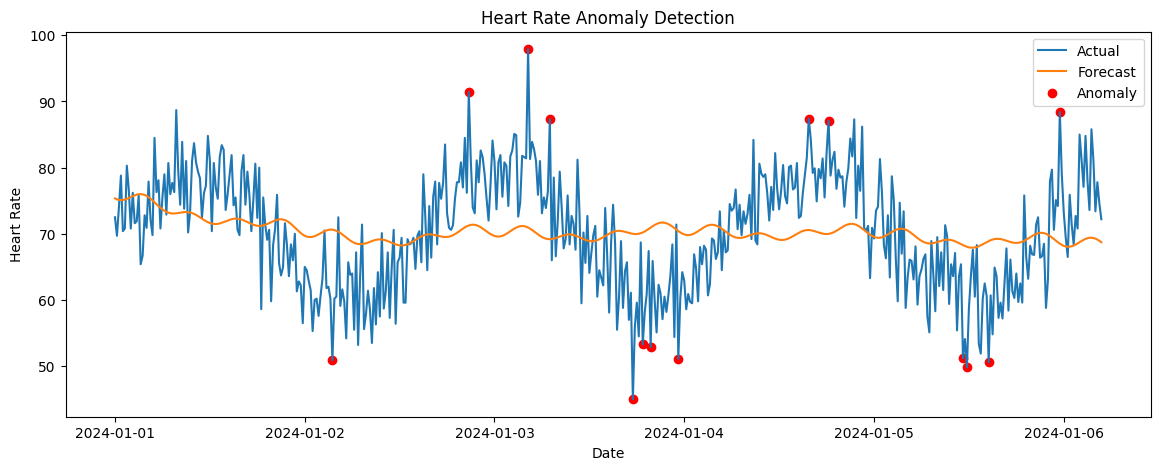

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(heart_df['ds'], heart_df['y'], label='Actual')
plt.plot(heart_df['ds'], heart_df['yhat'], label='Forecast')

plt.scatter(
    heart_df[heart_df['anomaly']]['ds'],
    heart_df[heart_df['anomaly']]['y'],
    color='red', label='Anomaly'
)

plt.title('Heart Rate Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Heart Rate')
plt.legend()
plt.savefig('heart_rate_anomalies.png')
plt.show()


In [ ]:
sleep_df.rename(columns={'date': 'ds', 'sleep_hours': 'y'}, inplace=True)
sleep_df['ds'] = pd.to_datetime(sleep_df['ds'])


In [ ]:
sleep_mean = sleep_df['y'].mean()
sleep_std = sleep_df['y'].std()

sleep_df['anomaly'] = (sleep_df['y'] < sleep_mean - sleep_std) | \
                      (sleep_df['y'] > sleep_mean + sleep_std)


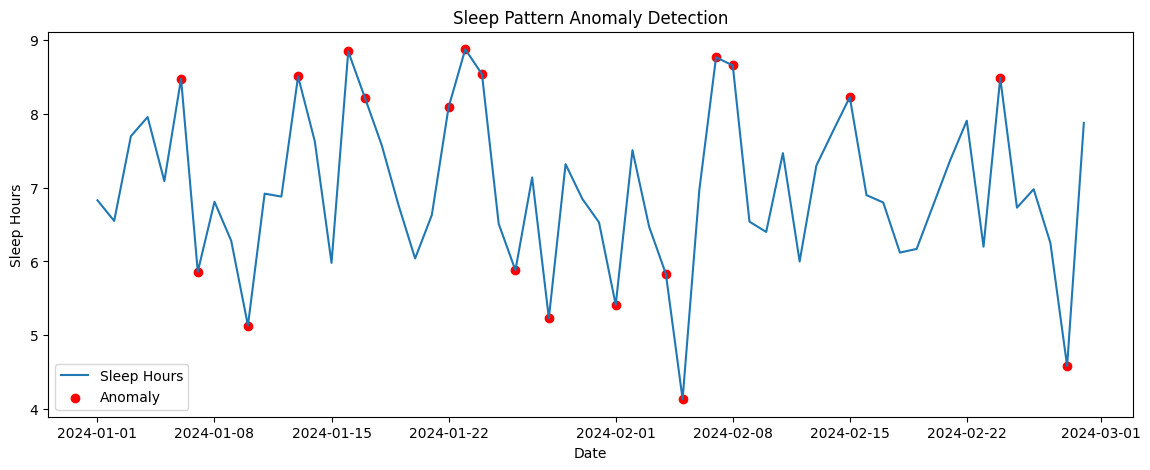

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(sleep_df['ds'], sleep_df['y'], label='Sleep Hours')

plt.scatter(
    sleep_df[sleep_df['anomaly']]['ds'],
    sleep_df[sleep_df['anomaly']]['y'],
    color='red', label='Anomaly'
)

plt.title('Sleep Pattern Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Sleep Hours')
plt.legend()
plt.savefig('sleep_anomalies.png')
plt.show()


In [ ]:
import os
os.makedirs('visualizations', exist_ok=True)

os.rename('heart_rate_anomalies.png', 'visualizations/heart_rate_anomalies.png')
os.rename('sleep_anomalies.png', 'visualizations/sleep_anomalies.png')
